# Softmax

The softmax strategy samples an action from a probability distribution over the action-value function, such that the probability of selecting an action is proportional to its current action-value estimate. The difference between Q-value estimates will create a tendency to select actions with the highest estimates more often, and actions with the lowest estimates less frequently.

In [1]:
import numpy as np

class BanditEnv:
    def __init__(self):
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [2]:
def decay_epsilon(init_value, min_value, decay_episodes, max_episodes):

    # calculate the number of the remaining episodes after the decay
    rem_episodes = max_episodes - decay_episodes
    
    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_episodes, base=10)
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_episodes), 'edge')
    
    return values

In [3]:
def decay_epsilon_greedy(env, init_epsilon=1, min_epsilon=0.001, decay_episodes=100, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    # Calculate the exponentially decaying epsilons. 
    epsilons = decay_epsilon(init_epsilon, min_epsilon, decay_episodes, n_episodes);
    
    for e in range(n_episodes):
        
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

In [4]:
def softmax(env, init_temp=1000, min_temp=0.1,
            decay_ratio=0.04,n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    for e in range(n_episodes):
        
        # calculate the linearly decaying temperature 
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        # calculate the probabilities by applying the softmax function 
        # to the estimates
        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
    
        # select the action based on probabilities
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

In [5]:
from tqdm import tqdm

returns_epsilon_decay = []
returns_softmax = []

envs = []
for i in range(2000):
    envs.append(BanditEnv());

for i in tqdm(range(2000), desc='Running epsilon decay'):
    returns, _, _ = decay_epsilon_greedy(env=envs[i]) 
    returns_epsilon_decay.append(returns); 
    
for i in tqdm(range(2000), desc='Running softmax method'):
    returns, _, _ = softmax(env=envs[i])
    returns_softmax.append(returns); 

returns_epsilon_decay = np.array(returns_epsilon_decay)
returns_softmax = np.array(returns_softmax)

Running epsilon decay:   0%|          | 0/2000 [00:00<?, ?it/s]

Running softmax method: 100%|██████████| 2000/2000 [00:59<00:00, 33.48it/s]


In [6]:
# Average reward
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0)
avg_reward_softmax = np.average(returns_softmax, axis=0)

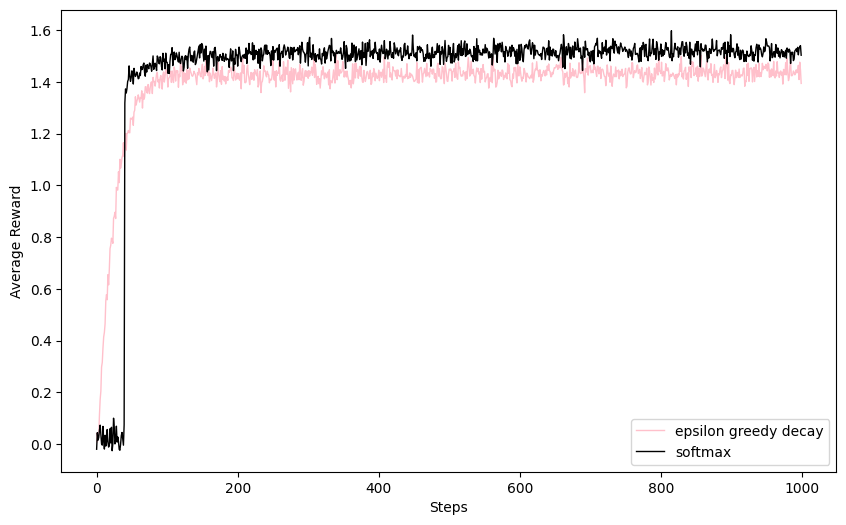

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(avg_reward_epsilon_decay, linewidth=1, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_softmax, linewidth=1, color='black',   label='softmax')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()